In [35]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
#%matplotlib inline
import pandas as pd
import corner
import corner
import time 
'''
MCMC fitting template. 
This template fits a 1-d gaussian, if you 
figure out how to use it for more complicated distributions
I'd appreciate if you let me know :)
banados@mpia.de
'''
np.random.seed(0)
#First let's create a gaussian data

#data = np.random.normal(loc=8, scale=.3, size=1000)
#plt.hist(data, bins = np.linspace(data.min(), data.max(), 20))
file_path = "../../../mnt/stability_stuff/stabilitydataset/data/LongTimeScale/"
planet_systems = np.loadtxt(file_path+"Order.txt", dtype = str)
print planet_systems
planet_sys = "Sys_2128_1e8.csv"
data =pd.read_csv("../../../mnt/stability_stuff/stabilitydataset/data/LongTimeScale/"+planet_sys, index_col = 0)
del data["Unnamed: 0.1"]
del data["runstring"]
data = np.log10(data["t"].values)
plt.hist(data, bins = 20)
sys_name = planet_sys.split("_")[1]




# Then, define the probability distribution that you would like to sample.
def lnprob(p, vec):
    diff = vec-p[0]
    N = len(vec)
    #probs = 
    if p[1] <=0:
        return -np.inf#0
    try:
        #probs =  -0.5 * N * np.log(2. * np.pi) - N * np.log(np.abs(p[1])) - 0.5 \
        #                            * np.sum(( (vec - p[0]) / p[1] ) ** 2)
        
        probs = -0.5 * N * np.log(2. * np.pi) - N/2. * np.log(np.abs(p[1])) - 0.5 \
                                    * np.sum(( (vec - p[0]) / p[1] ) ** 2)
        
    except:
        probs = 0.00
        #int probs, "NANS"
        #return probs
        
    #rint probs
    return probs
    
    
def log_prob_normed(mu, sigma, info):
    prob = -np.log(2*np.pi)/2. - np.log(sigma**2.)/2.-(1./(sigma**2.)/2./info.shape[0])*np.nansum((info-mu)**2.)
    return prob

                                      

print planet_systems.shape


['Sys_10518_1e8.csv' 'Sys_1174_1e8.csv' 'Sys_12073_1e8.csv'
 'Sys_12840_1e8.csv' 'Sys_13362_1e8.csv' 'Sys_15003_1e8.csv'
 'Sys_15220_1e8.csv' 'Sys_16588_1e8.csv' 'Sys_17641_1e8.csv'
 'Sys_18539_1e8.csv' 'Sys_18651_1e8.csv' 'Sys_19197_1e8.csv'
 'Sys_19591_1e8.csv' 'Sys_19898_1e8.csv' 'Sys_20041_1e8.csv'
 'Sys_2008_1e8.csv' 'Sys_2010_1e8.csv' 'Sys_20620_1e8.csv'
 'Sys_20972_1e8.csv' 'Sys_2128_1e8.csv' 'Sys_21872_1e8.csv'
 'Sys_22_1e8.csv' 'Sys_22998_1e8.csv' 'Sys_23005_1e8.csv'
 'Sys_23975_1e8.csv' 'Sys_24008_1e8.csv' 'Sys_24013_1e8.csv'
 'Sys_24017_1e8.csv' 'Sys_24248_1e8.csv' 'Sys_24346_1e8.csv'
 'Sys_24453_1e8.csv' 'Sys_24576_1e8.csv' 'Sys_24631_1e8.csv'
 'Sys_24705_1e8.csv' 'Sys_24763_1e8.csv' 'Sys_24824_1e8.csv'
 'Sys_24930_1e8.csv' 'Sys_3000_1e8.csv' 'Sys_3898_1e8.csv' 'Sys_42_1e8.csv'
 'Sys_4753_1e8.csv' 'Sys_5505_1e8.csv' 'Sys_5958_1e8.csv' 'Sys_67_1e8.csv'
 'Sys_7341_1e8.csv' 'Sys_7431_1e8.csv' 'Sys_8462_1e8.csv'
 'Sys_8744_1e8.csv']
(48,)


In [45]:
#file_path = "../../../mnt/stability_stuff/stabilitydataset/data/LongTimeScale/"
#planet_systems = np.loadtxt(file_path+"Order.txt", dtype = str)
#print planet_systems
#planet_sys = "Sys_24576_1e8.csv"

#data.head()
values = np.zeros((planet_systems.shape[0], 6), dtype=str)
info = pd.DataFrame(values, columns=["ID", "Probability", "Mean", "Sigma", "Mean_Error", "Sigma_Error"])
info.head()



for jj, planet_sys in enumerate(planet_systems):

    np.random.seed(jj)
    data =pd.read_csv("../../../mnt/stability_stuff/stabilitydataset/data/LongTimeScale/"+planet_sys, index_col = 0)
    del data["Unnamed: 0.1"]
    del data["runstring"]
    data = data[data["t"]<1e8]
    #print data.shape
    data = np.log10(data["t"].values)
    plt.hist(data, bins = 20)

    sys_name = planet_sys.split("_")[1]
    print sys_name
    if data.max()<4:
        info.loc[jj] = [sys_name]+[np.nan]*5

        continue
    
    ndim = 2
    nwalkers = 20

    # Choose an initial set of positions for the walkers.
    p0 = [np.random.rand(ndim) for i in xrange(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[data], a=5)
    #print "State", sampler.random_state
    
    # Run 200 steps as a burn-in.
    print "Burning in ..."
    pos, prob, state = sampler.run_mcmc(p0, 200)

    # Reset the chain to remove the burn-in samples.
    sampler.reset()
    
    # Starting from the final position in the burn-in chain, sample for 1000
    # steps. (rstate0 is the state of the internal random number generator)
    print "Running MCMC ..."
    start = time.time()
    pos, prob, state = sampler.run_mcmc(pos, 1000, rstate0=jj)
    end = time.time()
    print "Done at ...", (end - start), "seconds." 
    # Print out the mean acceptance fraction. In general, acceptance_fraction
    # has an entry for each walker so, in this case, it is a 250-dimensional
    # vector.
    af = sampler.acceptance_fraction
    print "Mean acceptance fraction:", np.mean(af)
    

    maxprob_indice = np.argmax(prob)
    mean_fit, sigma_fit = pos[maxprob_indice]
    sigma_fit = np.abs(sigma_fit)
    #print "Estimated parameters: mean, sigma = %f, %f" % (mean_fit, sigma_fit)

    mean_samples = sampler.flatchain[:,0]
    sigma_samples = sampler.flatchain[:,1]

    mean_std = mean_samples.std()
    sigma_std =np.std(np.abs(sigma_samples) )

    #print "parameters' error: mean, sigma = %f, %f" % (mean_std, sigma_std)

    ##PLOT SAMPLING SPACE
    fig = plt.figure(figsize=(15, 8))
    ax =fig.add_subplot("121")
    ax2 = fig.add_subplot("122")
    ax.hist(mean_samples, 100)
    ax.set_title("Samples for Mean - Optimal at " + str("{0:.4f}".format(mean_fit))+ " + "+ str("{0:.4f}".format(mean_std)))
    ax2.set_title("Samples for Sigma - Optimal at " + str("{0:.4f}".format(sigma_fit))+ " + "+ str("{0:.4f}".format(sigma_std)))
    ax2.hist(sigma_samples,  bins = np.linspace(np.min(np.abs(sigma_samples)), np.max(sigma_samples), 100))
    fig.suptitle("Parameters for System "+sys_name)
    fig.savefig("../../MLstability/Figures/MCMCFigures/Parameters_"+sys_name, bbox_inches='tight')
    #plt.show()
    
    
    
    
    ##PLOT CORNER PLOT
    probability = log_prob_normed(mean_fit, sigma_fit, data)
    #print "Probability", np.exp(probability), "Shape", data.shape[0]
    
    samples = sampler.chain[:, :, :].reshape((-1, ndim))
    fig = plt.figure(figsize=(12, 12))
    fig = corner.corner(samples, labels=["$m$", "$s$"],  figsize = (12, 12))
    fig.suptitle("MCMC fit for Mu and Sigma for System "+ sys_name + " with Probability of "+ str("{:.4f}".format(np.exp(probability))))
    fig.savefig("../../MLstability/Figures/MCMCFigures/System_"+sys_name, bbox_inches='tight')
    #plt.show()
    
       
    #SAVE INFO OF INTEREST
    
    if probability>1:
        info.loc[jj] = [sys_name]+[np.inf]*5

    else:
        info.loc[jj] = [sys_name, np.exp(probability), mean_fit, sigma_fit, mean_std, sigma_std]
    print sys_name , probability, np.exp(probability),"\n"
  

    

    #break

10518
Burning in ...
Running MCMC ...
Done at ... 0.982122182846 seconds.
Mean acceptance fraction: 0.4326
10518 -0.669432127937 0.511999245315 

1174
Burning in ...
Running MCMC ...
Done at ... 0.975095033646 seconds.
Mean acceptance fraction: 0.4379
1174 -0.0857600152615 0.917814466257 

12073
Burning in ...
Running MCMC ...
Done at ... 0.966448068619 seconds.
Mean acceptance fraction: 0.4343
12073 -0.867846851861 0.419854585833 

12840
Burning in ...
Running MCMC ...
Done at ... 0.967673063278 seconds.
Mean acceptance fraction: 0.4394
12840 -1.03072325747 0.356748845971 

13362
Burning in ...
Running MCMC ...
Done at ... 0.963469028473 seconds.
Mean acceptance fraction: 0.4408
13362 -0.565213669388 0.568238718566 

15003
Burning in ...
Running MCMC ...
Done at ... 0.984125852585 seconds.
Mean acceptance fraction: 0.44025
15003 -0.733570867089 0.480191225917 

15220
Burning in ...
Running MCMC ...
Done at ... 0.998021125793 seconds.
Mean acceptance fraction: 0.4325
15220 -0.514850888

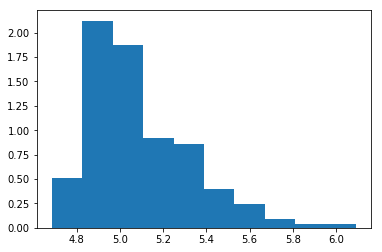

,ID,Probability,Mean,Sigma,Mean_Error,Sigma_Error
0,10518,0.511999,6.4694,0.604505,0.0197145,0.019823
1,1174,0.917814,5.25656,0.339335,0.0108144,0.0109241
2,12073,0.419855,4.52122,0.739037,0.0231842,0.0239695
3,12840,0.356749,4.71374,0.872946,0.0269679,0.0275104
4,13362,0.568239,2.07742,0.545216,0.0177063,0.0174054
5,15003,0.480191,6.75394,0.645291,0.0210221,0.0210572
6,15220,0.59759,5.81274,0.522419,0.0163449,0.016537
7,16588,0.477175,6.62747,0.648943,0.0209239,0.0209389
8,17641,0.566064,5.44977,0.549561,0.017299,0.0178241
9,18539,0.419277,6.81389,0.745437,0.0238467,0.0244848


In [63]:
#weird_probs = info[info["Probability"]>=1]
#print weird_probs
weird_data = pd.read_csv("../../../mnt/stability_stuff/stabilitydataset/data/LongTimeScale/Sys_24576_1e8.csv")
plt.figure()
times = np.log10(weird_data["t"])
#weird_data.hist("t")
plt.hist(times, normed =1)
plt.show()
info

In [53]:
"{0:.4f}".format(31214.41)
print planet_systems.shape, info.shape
#info.to_csv
info.to_csv("../Figures/MCMCFigures/ProababilityTable.csv")
info

(48,) (48, 6)


,ID,Probability,Mean,Sigma,Mean_Error,Sigma_Error
0,10518,0.511999,6.4694,0.604505,0.0197145,0.019823
1,1174,0.917814,5.25656,0.339335,0.0108144,0.0109241
2,12073,0.419855,4.52122,0.739037,0.0231842,0.0239695
3,12840,0.356749,4.71374,0.872946,0.0269679,0.0275104
4,13362,0.568239,2.07742,0.545216,0.0177063,0.0174054
5,15003,0.480191,6.75394,0.645291,0.0210221,0.0210572
6,15220,0.59759,5.81274,0.522419,0.0163449,0.016537
7,16588,0.477175,6.62747,0.648943,0.0209239,0.0209389
8,17641,0.566064,5.44977,0.549561,0.017299,0.0178241
9,18539,0.419277,6.81389,0.745437,0.0238467,0.0244848


In [ ]:
#repeat with one system, and plot how the error changes as you change how many points you sample

In [34]:
#file_path = "../../../mnt/stability_stuff/stabilitydataset/data/LongTimeScale/"
#planet_systems = np.loadtxt(file_path+"Order.txt", dtype = str)
#print planet_systems
#planet_sys = "Sys_24576_1e8.csv"

#data.head()
#plt.hist(data, bins = 20)


vals = np.linspace(100,1000,19)
overall_mean = np.zeros_like(vals)
print overall_mean.shape
overall_sigma = np.zeros_like(vals)
mean_error = np.zeros_like(vals)
sigma_error = np.zeros_like(vals)

print vals
nwalkers = 250

for j,val in enumerate(vals):
    data =pd.read_csv("../../../mnt/stability_stuff/stabilitydataset/data/LongTimeScale/Sys_10518_1e8.csv", index_col = 0)
    del data["Unnamed: 0.1"]
    del data["runstring"]
    data = np.log10(data["t"].values)
    data= data[:int(val)]
    sys_name = planet_sys.split("_")[1]
    print sys_name, data.shape
    # We'll sample a Gaussian which has 2 parameters: mean and sigma...
    ndim = 2
    
    # We'll sample with 250 walkers. (nwalkers must be an even number)

    # Choose an initial set of positions for the walkers.
    p0 = [np.random.rand(ndim) for i in xrange(nwalkers)]

    # Initialize the sampler with the chosen specs.
    #The "a" parameter controls the step size, the default is a=2,
    #but in this case works better with a=4 see below or page 10 in the paper
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[data], a=5)

    # Run 200 steps as a burn-in.
    print "Burning in ..."
    pos, prob, state = sampler.run_mcmc(p0, 200)

    # Reset the chain to remove the burn-in samples.
    sampler.reset()

    # Starting from the final position in the burn-in chain, sample for 1000
    # steps. (rstate0 is the state of the internal random number generator)
    print "Running MCMC ..."
    start = time.time()
    pos, prob, state = sampler.run_mcmc(pos, 1000, rstate0=state)
    end = time.time()
    print "Done at ...", (end - start), "seconds." 
  
    
    maxprob_indice = np.argmax(prob)
    print "Max prob", np.max(prob)
    mean_fit, sigma_fit = pos[maxprob_indice]
    sigma_fit = np.abs(sigma_fit)
    print "Estimated parameters: mean, sigma = %f, %f" % (mean_fit, sigma_fit)

    mean_samples = sampler.flatchain[:,0]
    sigma_samples = sampler.flatchain[:,1]

    mean_std = mean_samples.std()
    sigma_std =np.std(np.abs(sigma_samples) )
    #sigma_samples.std()

    print "parameters' error: mean, sigma = %f, %f" % (mean_std, sigma_std)

  
    print mean_fit, sigma_fit, j
    overall_mean[j]= mean_fit
    
    overall_sigma[j] = sigma_fit
    mean_error[j] = mean_std
    sigma_error[j]= sigma_std
    x = np.arange(pos.shape[0])
    print x.shape, pos.shape
    #plt.plot(x, pos[:, 0])
    #plt.show()
    #plt.figure()
    #plt.plot(x ,pos[:, 1])
    #plt.show()
    #break
    
    #print log_prob_normed(mean_fit-1, sigma_fit-1, data)


(19,)
[  100.   150.   200.   250.   300.   350.   400.   450.   500.   550.
   600.   650.   700.   750.   800.   850.   900.   950.  1000.]
10518 (100,)
Burning in ...
Running MCMC ...
Done at ... 6.91495800018 seconds.
Max prob -52.0144564827
Estimated parameters: mean, sigma = 6.528864, 0.407383
parameters' error: mean, sigma = 0.041472, 0.029750
6.52886422293 0.407382978054 0
(250,) (250, 2)
10518 (150,)
Burning in ...
Running MCMC ...
Done at ... 7.38945889473 seconds.
Max prob -76.9158398522
Estimated parameters: mean, sigma = 6.491855, 0.401857
parameters' error: mean, sigma = 0.033380, 0.023915
6.49185544331 0.401856848521 1
(250,) (250, 2)
10518 (200,)
Burning in ...
Running MCMC ...
Done at ... 7.43438982964 seconds.
Max prob -106.629933233
Estimated parameters: mean, sigma = 6.485075, 0.411897
parameters' error: mean, sigma = 0.029208, 0.020865
6.48507455163 0.411896564026 2
(250,) (250, 2)
10518 (250,)
Burning in ...
Running MCMC ...
Done at ... 7.57039880753 seconds.
Max 

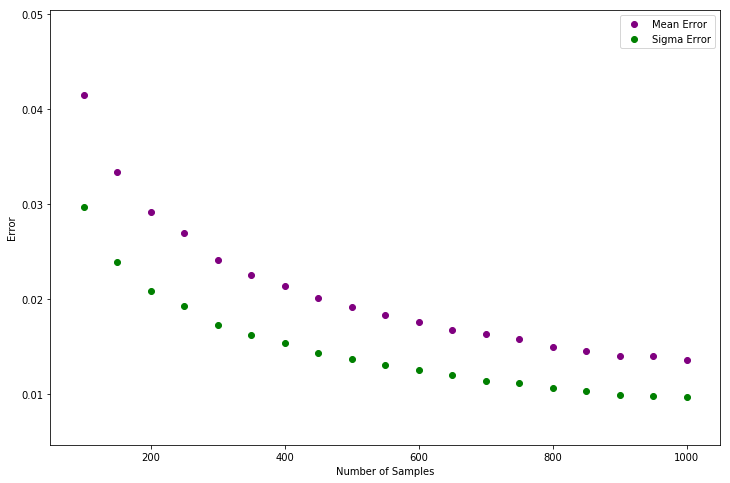

In [36]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot("111")
#ax.scatter(vals, overall_mean)
#ax.scatter(vals, overall_sigma)
ax.scatter(vals, mean_error, color = "purple", label = "Mean Error")
ax.scatter(vals, sigma_error, color = "green", label = "Sigma Error")
ax.legend(loc = 0)
ax.set_xlabel("Number of Samples")
ax.set_ylabel("Error")
#fig.savefig("../../MLstability/Figures/MCMCFigures/Error", bbox_inches='tight')
plt.show()

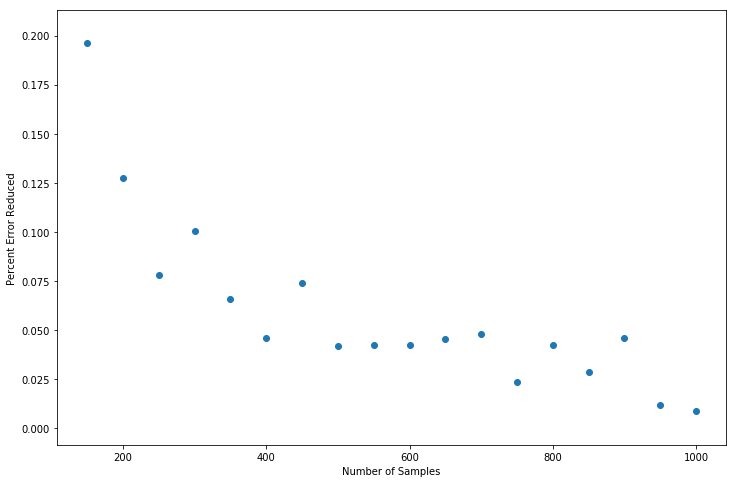

In [37]:
#make a plot of the reduction of error for each step 
#error reduced = (err2 - err1)/err1
fig = plt.figure(figsize=(12, 8))
sig_error_reduces = np.zeros(vals.shape[0]-1)
for i in range(sig_error_reduces.shape[0]):
    sig_error_reduces[i] = (sigma_error[i] - sigma_error[i+1]) / sigma_error[i]
plt.scatter(vals[1:], sig_error_reduces)
plt.ylabel("Percent Error Reduced")
plt.xlabel("Number of Samples")
#fig.savefig("../../MLstability/Figures/MCMCFigures/PercentErrorReduced.png", bbox_inches='tight')
plt.show()

In [39]:
np.logspace(1, 7, 20)

array([  1.00000000e+01,   2.06913808e+01,   4.28133240e+01,
         8.85866790e+01,   1.83298071e+02,   3.79269019e+02,
         7.84759970e+02,   1.62377674e+03,   3.35981829e+03,
         6.95192796e+03,   1.43844989e+04,   2.97635144e+04,
         6.15848211e+04,   1.27427499e+05,   2.63665090e+05,
         5.45559478e+05,   1.12883789e+06,   2.33572147e+06,
         4.83293024e+06,   1.00000000e+07])

In [63]:
#try logspace with generated gaussian
np.random.seed(0)
#First let's create a gaussian data
data = np.random.normal(loc=8, scale=.3, size=int(1e7))
print data.shape
vals =  np.logspace(1, 6, 15)

#file_path = "../../../mnt/stability_stuff/stabilitydataset/data/LongTimeScale/"
#planet_systems = np.loadtxt(file_path+"Order.txt", dtype = str)
#print planet_systems
#planet_sys = "Sys_24576_1e8.csv"

#data.head()
#plt.hist(data, bins = 20)

(10000000,)


In [64]:
def run_error_analysis(vals, total_data):
    #np.linspace(100,1000,19)
    overall_mean = np.zeros_like(vals)
    print overall_mean.shape
    overall_sigma = np.zeros_like(vals)
    mean_error = np.zeros_like(vals)
    sigma_error = np.zeros_like(vals)

    print vals
    nwalkers = 20


    for j,val in enumerate(vals):
        #print data.shape, 
        data= total_data[:int(val)]
        print val, data.shape
        #sys_name = planet_sys.split("_")[1]
        #print sys_name, data.shape
        # We'll sample a Gaussian which has 2 parameters: mean and sigma...
        ndim = 2

        # We'll sample with 250 walkers. (nwalkers must be an even number)

        # Choose an initial set of positions for the walkers.
        p0 = [np.random.rand(ndim) for i in xrange(nwalkers)]

        # Initialize the sampler with the chosen specs.
        #The "a" parameter controls the step size, the default is a=2,
        #but in this case works better with a=4 see below or page 10 in the paper
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[data], a=5)

        # Run 200 steps as a burn-in.
        #print "Burning in ..."
        pos, prob, state = sampler.run_mcmc(p0, 200)

        # Reset the chain to remove the burn-in samples.
        sampler.reset()

        # Starting from the final position in the burn-in chain, sample for 1000
        # steps. (rstate0 is the state of the internal random number generator)
        #print "Running MCMC ..."
        start = time.time()
        pos, prob, state = sampler.run_mcmc(pos, 1000, rstate0=state)
        end = time.time()
        print "Done at ...", (end - start), "seconds." 


        maxprob_indice = np.argmax(prob)
        #print "Max prob", np.max(prob)
        mean_fit, sigma_fit = pos[maxprob_indice]
        sigma_fit = np.abs(sigma_fit)
        #print "Estimated parameters: mean, sigma = %f, %f" % (mean_fit, sigma_fit)

        mean_samples = sampler.flatchain[:,0]
        sigma_samples = sampler.flatchain[:,1]

        mean_std = mean_samples.std()
        sigma_std =np.std(np.abs(sigma_samples) )
        #sigma_samples.std()

        #print "parameters' error: mean, sigma = %f, %f" % (mean_std, sigma_std)


        #print mean_fit, sigma_fit, j
        overall_mean[j]= mean_fit

        overall_sigma[j] = sigma_fit
        mean_error[j] = mean_std
        sigma_error[j]= sigma_std
        x = np.arange(pos.shape[0])
        #print x.shape, pos.shape
        print "\n"
        #print log_prob_normed(mean_fit-1, sigma_fit-1, data)
    return overall_mean, overall_sigma, mean_error, sigma_error


In [65]:
overall_mean, overall_sigma, mean_error, sigma_error = run_error_analysis(vals, data)

(15,)
[  1.00000000e+01   2.27584593e+01   5.17947468e+01   1.17876863e+02
   2.68269580e+02   6.10540230e+02   1.38949549e+03   3.16227766e+03
   7.19685673e+03   1.63789371e+04   3.72759372e+04   8.48342898e+04
   1.93069773e+05   4.39397056e+05   1.00000000e+06]
10.0 (10,)
Done at ... 0.776919841766 seconds.


22.7584592607 (22,)
Done at ... 0.792902946472 seconds.


51.7947467923 (51,)
Done at ... 0.816807031631 seconds.


117.876863479 (117,)
Done at ... 0.816536188126 seconds.


268.269579528 (268,)
Done at ... 0.864029884338 seconds.


610.540229659 (610,)
Done at ... 0.924199819565 seconds.


1389.49549437 (1389,)
Done at ... 1.03450107574 seconds.


3162.27766017 (3162,)
Done at ... 1.23071885109 seconds.


7196.85673001 (7196,)
Done at ... 1.69460201263 seconds.


16378.9370695 (16378,)
Done at ... 2.73704385757 seconds.


37275.9372031 (37275,)
Done at ... 5.23797011375 seconds.


84834.2898244 (84834,)
Done at ... 10.1045470238 seconds.


193069.772888 (193069,)
Done at ...

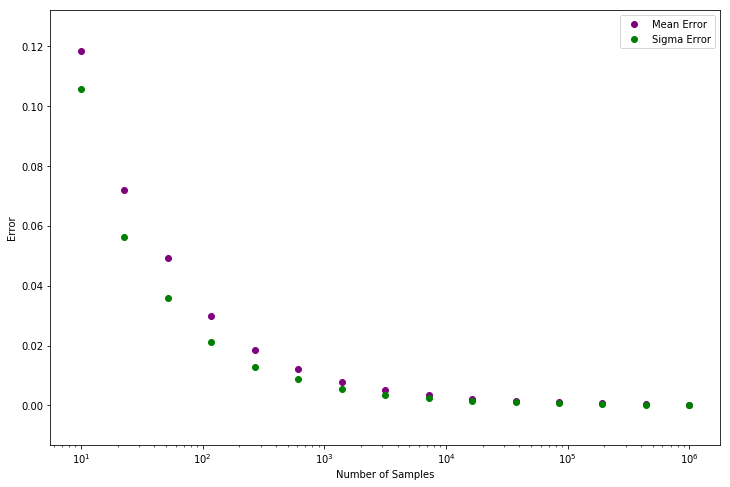

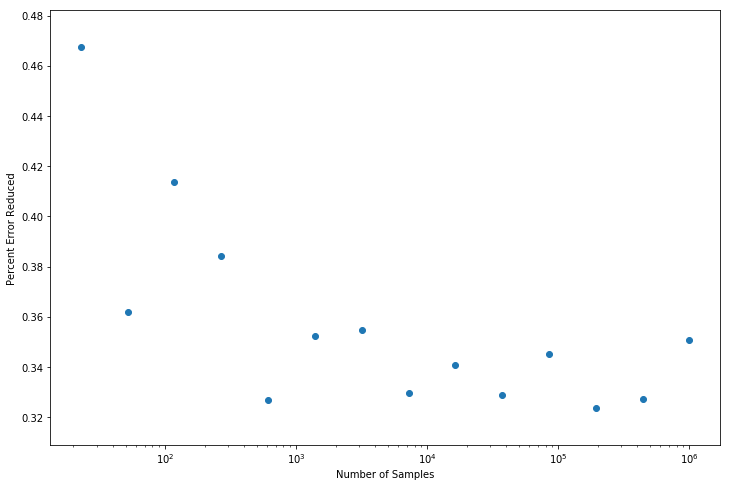

In [70]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot("111")
#ax.scatter(vals, overall_mean)
#ax.scatter(vals, overall_sigma)
ax.scatter(vals, mean_error, color = "purple", label = "Mean Error")
ax.scatter(vals, sigma_error, color = "green", label = "Sigma Error")
ax.legend(loc = 0)
ax.set_xlabel("Number of Samples")
ax.set_ylabel("Error")
ax.set_xscale("log")

#fig.savefig("../../MLstability/Figures/MCMCFigures/Error", bbox_inches='tight')
plt.show()

#make a plot of the reduction of error for each step 
#error reduced = (err2 - err1)/err1
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot("111")
sig_error_reduces = np.zeros(vals.shape[0]-1)
for i in range(sig_error_reduces.shape[0]):
    sig_error_reduces[i] = (sigma_error[i] - sigma_error[i+1]) / sigma_error[i]
ax.scatter(vals[1:], sig_error_reduces)
ax.set_ylabel("Percent Error Reduced")
ax.set_xlabel("Number of Samples")
ax.set_xscale("log")

#fig.savefig("../../MLstability/Figures/MCMCFigures/PercentErrorReduced.png", bbox_inches='tight')
plt.show()

In [75]:
vals =  np.logspace(1, 4, 15)
print vals
overall_mean, overall_sigma, mean_error, sigma_error = run_error_analysis(vals, data)


[    10.             16.37893707     26.82695795     43.93970561
     71.9685673     117.87686348    193.06977289    316.22776602
    517.94746792    848.34289824   1389.49549437   2275.84592607
   3727.59372031   6105.40229659  10000.        ]
(15,)
[    10.             16.37893707     26.82695795     43.93970561
     71.9685673     117.87686348    193.06977289    316.22776602
    517.94746792    848.34289824   1389.49549437   2275.84592607
   3727.59372031   6105.40229659  10000.        ]
10.0 (10,)
Done at ... 0.786319971085 seconds.


16.3789370695 (16,)
Done at ... 0.790235996246 seconds.


26.8269579528 (26,)
Done at ... 0.804243087769 seconds.


43.9397056076 (43,)
Done at ... 0.853454828262 seconds.


71.9685673001 (71,)
Done at ... 0.867842912674 seconds.


117.876863479 (117,)
Done at ... 0.866768836975 seconds.


193.069772888 (193,)
Done at ... 0.905980825424 seconds.


316.227766017 (316,)
Done at ... 0.92834687233 seconds.


517.947467923 (517,)
Done at ... 0.957716941833

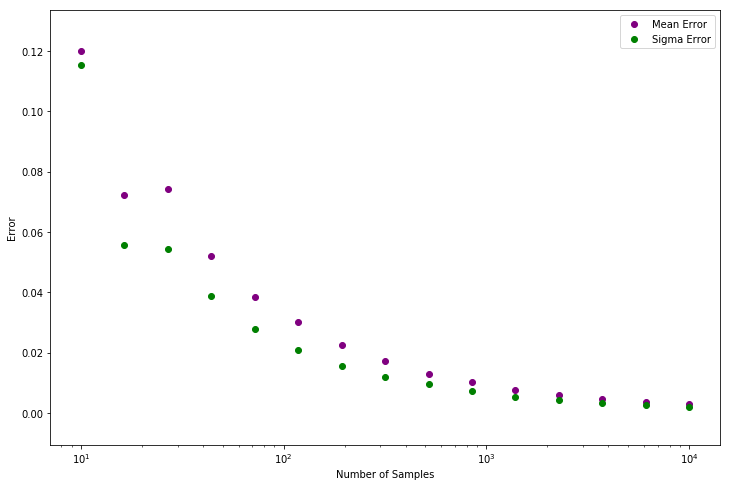

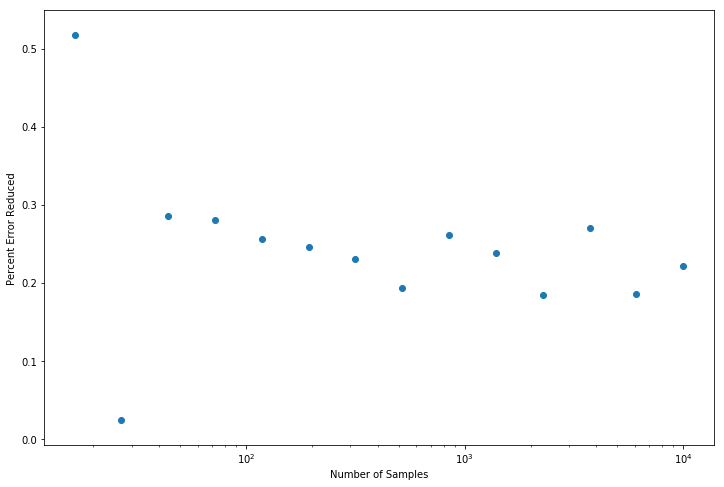

In [77]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot("111")
#ax.scatter(vals, overall_mean)
#ax.scatter(vals, overall_sigma)
ax.scatter(vals, mean_error, color = "purple", label = "Mean Error")
ax.scatter(vals, sigma_error, color = "green", label = "Sigma Error")
ax.legend(loc = 0)
ax.set_xlabel("Number of Samples")
ax.set_ylabel("Error")
ax.set_xscale("log")

#fig.savefig("../../MLstability/Figures/MCMCFigures/Error", bbox_inches='tight')
plt.show()

#make a plot of the reduction of error for each step 
#error reduced = (err2 - err1)/err1
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot("111")
sig_error_reduces = np.zeros(vals.shape[0]-1)
for i in range(sig_error_reduces.shape[0]):
    sig_error_reduces[i] = (sigma_error[i] - sigma_error[i+1]) / sigma_error[i]
ax.scatter(vals[1:], sig_error_reduces)
ax.set_ylabel("Percent Error Reduced")
ax.set_xlabel("Number of Samples")
ax.set_xscale("log")

#fig.savefig("../../MLstability/Figures/MCMCFigures/PercentErrorReduced.png", bbox_inches='tight')
plt.show()